# 1. 데이터 & 라이브러리 로드

In [17]:
#pip install pyspark
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# Pyspark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Pyspark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

sc = SparkContext.getOrCreate() 

In [18]:
# SparkSession 생성
spark = SparkSession.builder\
        .appName('Play with pypsark ML on Titanic Data')\
        .getOrCreate()
# 데이터 로드
df = spark.read.csv('titanic/train.csv', header=True, inferSchema=True)
# toPandas()를 이용해 판다스에서 제공하는 데이터프레임 형태로 출력
df.limit(3).toPandas()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [19]:
df#.limit(3)
df.toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"""Johnston, Miss. Catherine Helen """"Carrie""""""",female,NaN,1,2,W./C. 6607,23.4500,None,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# 2. 시각화

pandas_df 타입: <class 'pandas.core.frame.DataFrame'>


C:\Users\REDTABLE\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


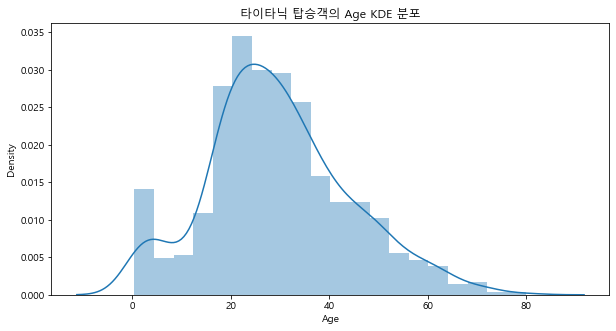

In [20]:
# Pandas 데이터프레임 형태로 우선 변환!
pandas_df = df.toPandas()
print("pandas_df 타입:", type(pandas_df))

# Seaborn 사용해보기
plt.figure(figsize=(10, 5))
plt.title("타이타닉 탑승객의 Age KDE 분포")
sns.distplot(pandas_df['Age'])
plt.show()

# 3. 데이터 확인 (결측치)

In [27]:
# 위 2가지 방법을 동시에 사용해보자!
# 결측치가 있는 변수를 체크하고 결측치가 몇 개 있는지 살펴보기

from pyspark.sql.functions import isnan, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])\
  .show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|       2|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [23]:
# Cabin 변수는 결측치가 50%가 넘기 때문에 해당 변수를 삭제하자
df = df.drop('Cabin')

In [25]:
# 새로운 파생변수를 생성한 데이터프레임을 새로 할당!
df = df.withColumn("Initial", regexp_extract(col("Name"),
                                            "([A-Za-z]+)\.", # ()이게 하나의 그룹임!
                                            1)) # 그룹 인덱스는 1부터!
df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+



In [28]:
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Initial 변수 값들로 그룹핑한 후 평균 Age 구하기
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [30]:
df = df.withColumn('Age',
                  when((df['Initial'] == 'Miss') & (df['Age'].isNull()),
                      22).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Other') & (df['Age'].isNull()),
                      46).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Master') & (df['Age'].isNull()),
                      5).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mr') & (df['Age'].isNull()),
                      33).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mrs') & (df['Age'].isNull()),
                      36).otherwise(df['Age']))

In [31]:
# Embarked 변수에도 결측치가 2개 있었는데 무엇인지 확인해보기
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [32]:
# Embarked의 결측치는 최빈값인 'S'로 대체해주기
df = df.na.fill({"Embarked": "S"})
# 결측치가 채워졌는지 다시 확인
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+



# 4. Feature Engineereing

In [33]:
# Family size라는 파생변수 생성
df = df.withColumn("Family_Size",
                  col('SibSp')+col('Parch')) # df['SibSp']도 가능!

# Alone이라는 Binary 파생변수 생성하는데, 우선 0으로 다 해놓기
df = df.withColumn('Alone', lit(0))
# 조건에 맞게 Alone 변수값 변경
df = df.withColumn('Alone',
                  when(col('Family_Size') == 0, 1)\
                  .otherwise(col('Alone')))

In [35]:
convert_cols = ['Sex', 'Embarked', 'Initial']

# 추후에 IndexToString할려면 indexer 객체를 사용하면 됨! 
indexer = [StringIndexer(inputCol=col,
                         outputCol=col+'_index').fit(df) for col in convert_cols]
for i in indexer:
    print(i)
    print('-'*80)

print(type(indexer))

StringIndexerModel: uid=StringIndexer_b13f9ea05235, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_d2e17507f7bb, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_15b710c27bac, handleInvalid=error
--------------------------------------------------------------------------------
<class 'list'>


In [36]:
# Pipeline을 이용해 stage에다가 실행 과정 담아 넘기기
pipeline = Pipeline(stages=indexer)
df = pipeline.fit(df).transform(df)

# 5. 데이터 삭제 및 정리 -> 최종 Feature 벡터 변환

In [37]:
un_cols = ["PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial"]

df = df.drop(*un_cols)
print("삭제 후 남은 칼럼들:", df.columns)

삭제 후 남은 칼럼들: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Alone', 'Sex_index', 'Embarked_index', 'Initial_index']


In [38]:
feature = VectorAssembler(inputCols = df.columns[1:],
                         outputCol='features')
feature_vector = feature.transform(df) # 데이터프레임 형태로 반환
print('feature type:', type(feature))
print('feature_vector type', type(feature_vector))

feature_vector.limit(3).toPandas()

feature type: <class 'pyspark.ml.feature.VectorAssembler'>
feature_vector type <class 'pyspark.sql.dataframe.DataFrame'>


,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


# 6. 데이터 분할 (학습, 테스트용)

In [40]:
titanic_df = feature_vector.select(['features', 'Survived'])

# split train, test
(train_df, test_df) = titanic_df.randomSplit([0.8, 0.2], seed=42)

# 7. 머신러닝 분류 모델 만들기

In [41]:
# 분류 모델 
from pyspark.ml.classification import LogisticRegression
# 파라미터 튜닝 & 교차 검증
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
# 파이프라인
from pyspark.ml import Pipeline
# 메트릭 얻는 라이브러리
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# ROC AUC(Sklearn)
from sklearn.metrics import roc_curve, auc


# 모델 정의
lr = LogisticRegression(labelCol='Survived')

# 튜닝할 파라미터 grid 정의
                                    # model.parameter 식으로 정의
paramGrid = ParamGridBuilder().addGrid(lr.regParam,
                                      (0.01, 0.1))\
                              .addGrid(lr.maxIter,
                                      (5, 10))\
                              .addGrid(lr.tol,
                                      (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam,
                                      (0.25, 0.75))\
                              .build()

# 교차검증 정의 - Pipeline식으로 정의
tvs = TrainValidationSplit(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                          trainRatio=0.8)
# 학습은 fit으로!
model = tvs.fit(train_df)
# 평가는 transform으로!
model_prediction = model.transform(test_df)

# 메트릭 평가
print('Accuracy:',
     MulticlassClassificationEvaluator(labelCol='Survived',
                                      metricName='accuracy').evaluate(model_prediction))
print('Precision:',
     MulticlassClassificationEvaluator(labelCol='Survived',
                                      metricName='weightedPrecision').evaluate(model_prediction))

Accuracy: 0.7724137931034483
Precision: 0.7807706802336538


In [42]:
model_prediction.show(10)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(10,[0,1,2,4,5],[...|       0|[0.17409014108672...|[0.54341294623747...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.44322077274478...|[0.60902620825810...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.57729065390143...|[0.64044374785207...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.76547005051275...|[0.68254016104816...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.32248213192038...|[0.78959437217300...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.45143440626374...|[0.81021909234478...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[2.01412161924857...|[0.88227180261759...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[2.21709183002428...|[0.90177389740750...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[2.38468449013664...|[0.9156519388

# 8. ROC Curve 시각화 & AUC Score 계산

In [44]:
# Evaluate ROC metric
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext

# SparkContext를 만들기
sc = SparkContext.getOrCreate()

# ROC 점수인 AUC를 계산 위해 Logistic를 적용해 나온 확률값과 레이블만 가져오기
results = model_prediction.select(['probability', 'Survived'])

# 확률값 - 레이블 set 준비시키기
# collect()로 모든 데이터 row retrieve(반환) - 리스트 형태로 반환
results_collect = results.collect()

# named tuple 형식이기 때문에 key 값으로 원하는 값을 불러올 수 있다!
print(results_collect[0])
print()
print('probability:', results_collect[0].probability)
print('Survived:', results_collect[0].Survived)

Row(probability=DenseVector([0.5434, 0.4566]), Survived=0)

probability: [0.5434129462374723,0.45658705376252773]
Survived: 0


Exception ignored in: <function JavaModelWrapper.__del__ at 0x000001885AB30550>
Traceback (most recent call last):
  File "C:\Users\REDTABLE\Anaconda3\lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'


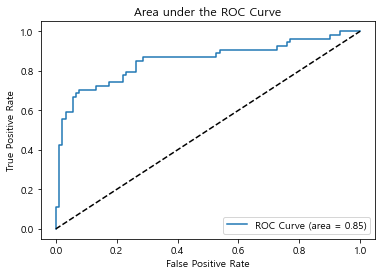

In [50]:
# Evaluate ROC metric
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext

# SparkContext를 만들기
sc = SparkContext.getOrCreate()

# ROC 점수인 AUC를 계산 위해 Logistic를 적용해 나온 확률값과 레이블만 가져오기
results = model_prediction.select(['probability', 'Survived'])

# 확률값 - 레이블 set 준비시키기
# collect()로 모든 데이터 row retrieve(반환) - 리스트 형태로 반환
results_collect = results.collect()
results_list = [(float(i.probability[1]),
                 float(i.Survived)) for i in results_collect]
# 여러개의 튜플이 담긴 list를 RDD 자료구조로 변경
scoreAndLabels = sc.parallelize(results_list)
# ROC metric 계산하기
    #metrics = metric(scoreAndLabels)
    #auc = metrics.areaUnderROC

# Visualize ROC Curve
from sklearn.metrics import roc_curve, auc

# roc_curve 는 실제값, 1로의 예측확률값을 인자로 넣어주면 FPR, TPR, 임곗값을 반환해줌
fpr = []
tpr = []
roc_auc = []

y_test = [i[1] for i in results_list]
y_proba = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
# x축엔 Fall-out(FPR), y축엔 Recall(TPR)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Area under the ROC Curve")
plt.legend(loc='lower right')
plt.show()